## Info

- 단순 제주도 위치정보 및 시각화를 위해 사용했던 파일로 PoC와 관련없음

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 0. 데이터확인
- 국가공간정보포털 (http://data.nsdi.go.kr/dataset/20001/resource/690ffe69-3ac9-49e6-9712-736bc6ab9db5)
- ascii 데이터 확인

제주도 경도/위도/고도 데이터 호출 

In [8]:
TXT_DATA = [i for i in os.listdir("data") if i.endswith(".txt")]
with open(f'data/{TXT_DATA[0]}') as f:
    data_jeju = f.readlines()
with open(f'data/{TXT_DATA[1]}') as f:
    data_seo = f.readlines()  
data = data_jeju+data_seo  

데이터 프레임으로 변환

In [17]:
x_lst,y_lst,z_lst = [],[],[]
for i in data:
    i = i.split("\n")[0]
    temp = i.split(" ")
    x,y,z = temp[0],temp[1],temp[2]
    x_lst.append(x) # 경도
    y_lst.append(y) # 위도
    z_lst.append(z) # 고도
x_arr = np.array(x_lst).astype("float32")
y_arr = np.array(y_lst).astype("float32")
z_arr = np.array(z_lst).astype("float32")
df = pd.DataFrame({"x":x_arr,"y":y_arr,"z":z_arr})
df["value"] = 1

print(f"경도 정보 // 최소:{np.min(x_arr)}, 최대:{np.max(x_arr)}")
print(f"위도 정보 // 최소:{np.min(y_arr)}, 최대:{np.max(y_arr)}")
print(f"고도 정보 // 최소:{np.min(z_arr)}, 최대:{np.max(z_arr)}")

경도 정보 // 최소:120241.328125, 최대:197461.328125
위도 정보 // 최소:58111.01953125, 최대:157721.796875
고도 정보 // 최소:0.09000000357627869, 최대:1914.739990234375


스케일링 및 데이터프레임 재지정

In [18]:
def min_max_scaling(data, new_min, new_max):
    '''위도, 경도 범위로 스케일링'''
    # 위도  331127～333350
    # 경도 1260843～1265820 ...
    min_val = min(data)
    max_val = max(data)
    scaled_data = [(x - min_val) / (max_val - min_val) * (new_max - new_min) + new_min for x in data]
    return scaled_data

def value_split_to_indices(data,split_num):
    '''고도별로 인덱스 지정'''
    min_val = min(data)
    max_val = max(data)
    bin_width = (max_val - min_val) / split_num
    bins = [min_val + i * bin_width for i in range(split_num+1)]
    indices = np.digitize(data, bins)
    return indices

scaled_X = min_max_scaling(x_arr,1260843,1265820)
scaled_Y = min_max_scaling(y_arr,331127,333350)
indices = value_split_to_indices(z_arr,20)

df["new_x"]=scaled_X
df["new_y"]=scaled_Y
df["new_z"]=z_lst
df["new_value"]=indices
df = df.astype("float32")

print(f"경도 정보 // 최소:{np.min(scaled_X)}, 최대:{np.max(scaled_X)}")
print(f"위도 정보 // 최소:{np.min(scaled_Y)}, 최대:{np.max(scaled_Y)}")
print(f"고도 정보 // 최소:{np.min(indices)}, 최대:{np.max(indices)}")

경도 정보 // 최소:1260843.0, 최대:1265820.0
위도 정보 // 최소:331127.0, 최대:333350.0
고도 정보 // 최소:1, 최대:20


시각화

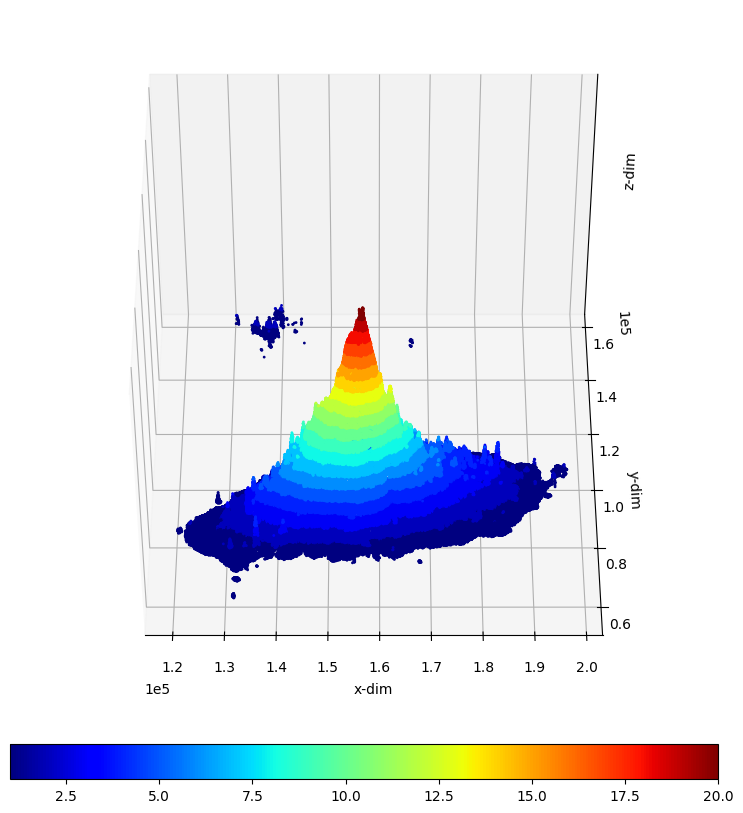

In [19]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
im=ax.scatter(df['x'], df['y'], df['z'], c=df['new_value'], s=1, alpha=1, cmap='jet')
plt.colorbar(im, fraction=0.046, pad=0.04, location='bottom')
plt.ticklabel_format(axis="both", style="sci", scilimits=(0, 0)) # 단위(지수승으로 표현)

# ax.set_xticks([])
# ax.set_yticks([])
ax.set_zticks([])
ax.set_xlabel("x-dim")
ax.set_ylabel("y-dim")
ax.set_zlabel("z-dim")
ax.view_init(45,270) # 위아래 방향 각도, 좌우 방향 각도

XY 평면

79678


Text(0.5, 1.0, 'Prediction')

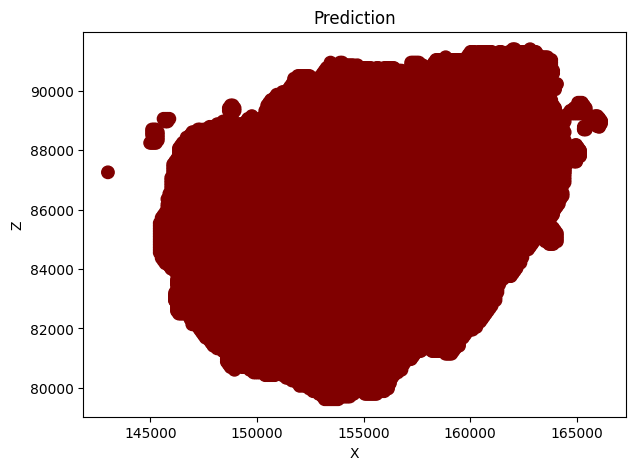

In [20]:
# z 좌표값 고정
default_z = sorted(list(set(df["z"])))
print(len(default_z))
condition_z = (df["z"]>=default_z[60000]) & (df["z"]<=default_z[-1])
x = df[condition_z]["x"]
y = df[condition_z]["y"]
val = df[condition_z]["new_value"]

# 플로팅
plt.figure(figsize=[7,5])
plt.scatter(x,y,c=val, marker="o", s=80, cmap='jet', label="Prediction", vmin=0, vmax=3)
plt.xlabel("X")
plt.ylabel("Z")
plt.title("Prediction")